# Multivariate LSTM Extended Example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import matplotlib.pyplot as plt

Load the data

In [2]:
df = pd.read_csv("SP500.csv")

Show the data

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [4]:
start_date = df.Date.min()
end_date = df.Date.max()

In [5]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [7]:
df = df.interpolate(method='linear', limit_direction='both')

Remove not needed columns

In [8]:
df = df[['Date', 'Close']].copy()

In [9]:
df

,Date,Close
0,2000-05-19,94.779701
1,2000-05-20,94.583211
2,2000-05-21,94.386721
3,2000-05-22,94.190231
4,2000-05-23,92.758675
...,...,...
7784,2021-09-10,447.540009
7785,2021-09-11,447.886668
7786,2021-09-12,448.233327
7787,2021-09-13,448.579987


**Simple Moving Average**
* Example periods: 15, 30 or 45 days

In [10]:
def computeSMA(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

In [11]:
df['SMA'] = computeSMA(df, period=15)

**Exponential Moving Averages**
* Example periods: 15, 30 or 45 days

In [12]:
def computeEMA(data, period, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [13]:
df['EMA'] = computeEMA(df, period=15)

**Relative Strength Index**

In [14]:
def computeRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = computeSMA(data, period, column='up')
    AVG_Loss = abs(computeSMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [15]:
df['RSI'] = computeRSI(df, period=14)

**Moving Average Convergence Divergence**

In [16]:
def MACD(data, period1=26, period2=12, signal=9, column='Close'):
    exp1 = computeEMA(data,period1, column=column)
    exp2 = computeEMA(data,period2, column=column)
    data['MACD'] = exp2 - exp1
    data['Signal Line'] = computeSMA(data, signal, column='MACD')

In [17]:
MACD(df)

Remove NaNs

In [18]:
df = df.dropna()

In [19]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
14,2000-06-02,99.663971,94.910938,95.600925,1.936874,0.000000,71.245582,0.680463,-0.042866
15,2000-06-03,99.446431,95.222053,96.081613,0.000000,-0.217539,71.115354,0.916439,0.090681
16,2000-06-04,99.228892,95.531765,96.475023,0.000000,-0.217539,70.985601,1.073524,0.250695
17,2000-06-05,99.011353,95.840074,96.792064,0.000000,-0.217539,70.856321,1.167008,0.420929
18,2000-06-06,98.506065,96.127796,97.006314,0.000000,-0.505287,77.029581,1.186644,0.585988
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Convert series to supervised learning

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]

    # Forecast sequence
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j+1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

Define input sequence

In [21]:
dataset = df.drop(["Date","up", "down"], axis=1)
values = dataset.values

Normalize features

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Frame as supervised learning

In [23]:
reframed = series_to_supervised(scaled, 1, 1)

In [24]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.115356,0.098279,0.099546,0.703972,0.750533,0.737481,0.114815,0.099061,0.100758,0.702632,0.758580,0.742507
2,0.114815,0.099061,0.100758,0.702632,0.758580,0.742507,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528
3,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934
4,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145
5,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145,0.114100,0.102414,0.103768,0.745909,0.769631,0.767096


Drop the columns not to be predicted

In [25]:
reframed.drop(reframed.columns[[7, 8, 9, 10, 11]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.115356,0.098279,0.099546,0.703972,0.750533,0.737481,0.114815
2,0.114815,0.099061,0.100758,0.702632,0.758580,0.742507,0.114274
3,0.114274,0.099841,0.101750,0.701296,0.763936,0.748528,0.113733
4,0.113733,0.100616,0.102549,0.699965,0.767123,0.754934,0.112476
5,0.112476,0.101340,0.103090,0.763519,0.767793,0.761145,0.114100


Split into train and test sets

In [26]:
values = reframed.values
n_train_days = values.shape[0]-10 # Last ten days are for validation
train = values[:n_train_days, :]
test = values[n_train_days:, :]

Split into input and outputs

In [27]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

Reshape input to be 3D [samples, timesteps, features]

In [28]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [29]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((7764, 1, 6), (7764,), (10, 1, 6), (10,))

Define model

In [30]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

In [31]:
model.compile(loss='mae', optimizer='adam')

Fit model

In [32]:
history = model.fit(train_X, train_y, 
                    epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Epoch 1/100
108/108 - 1s - loss: 0.0417 - val_loss: 0.0713
Epoch 2/100
108/108 - 0s - loss: 0.0787 - val_loss: 0.0308
Epoch 3/100
108/108 - 0s - loss: 0.0378 - val_loss: 0.0056
Epoch 4/100
108/108 - 0s - loss: 0.0103 - val_loss: 0.0055
Epoch 5/100
108/108 - 0s - loss: 0.0092 - val_loss: 0.0051
Epoch 6/100
108/108 - 0s - loss: 0.0072 - val_loss: 0.0038
Epoch 7/100
108/108 - 0s - loss: 0.0081 - val_loss: 0.0115
Epoch 8/100
108/108 - 0s - loss: 0.0092 - val_loss: 0.0025
Epoch 9/100
108/108 - 0s - loss: 0.0059 - val_loss: 0.0089
Epoch 10/100
108/108 - 0s - loss: 0.0083 - val_loss: 0.0040
Epoch 11/100
108/108 - 0s - loss: 0.0056 - val_loss: 0.0106
Epoch 12/100
108/108 - 0s - loss: 0.0091 - val_loss: 0.0030
Epoch 13/100
108/108 - 0s - loss: 0.0067 - val_loss: 0.0140
Epoch 14/100
108/108 - 0s - loss: 0.0097 - val_loss: 0.0066
Epoch 15/100
108/108 - 0s - loss: 0.0057 - val_loss: 0.0117
Epoch 16/100
108/108 - 0s - loss: 0.0091 - val_loss: 0.0029
Epoch 17/100
108/108 - 0s - loss: 0.0065 - val_lo

Plot history

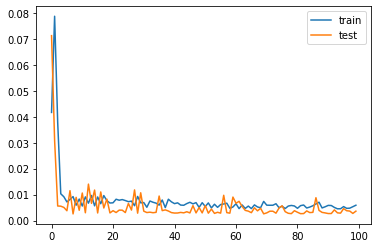

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Demonstrate training

In [34]:
yhat = model.predict(train_X)

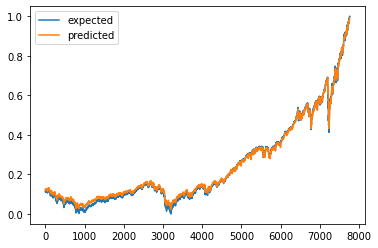

In [35]:
plt.plot(train_y, label='expected')
plt.plot(yhat.ravel(), label='predicted')
plt.legend()
plt.show()

Demonstrate prediction

In [36]:
yhat = model.predict(test_X)

In [37]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {test_y[0]:.2f}")

Predicted: 0.99  Expected: 1.00


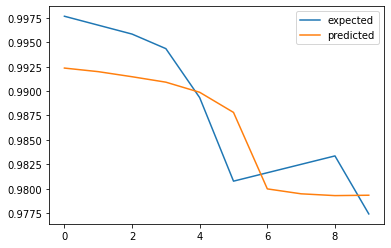

In [38]:
plt.plot(test_y, label='expected')
plt.plot(yhat.ravel(), label='predicted')
plt.legend()
plt.show()

**THIS IS NOT AN INVESTMENT ADVICE!**